In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [31]:
max_features = 500
rho = 0.5
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [32]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-6.748758432504194


### Get $S$ bootstrap replications under H0

In [33]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

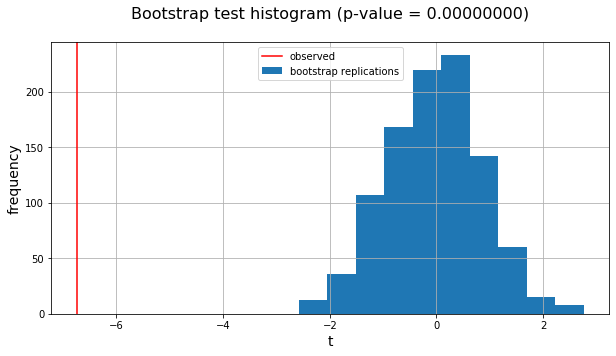

In [34]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");